# 1. Initial Set Up

### 1.1 Simulation Scenario

- There are 3 airlines, FOP Airlines, CHV Airlines and ABJ Airlines. 
- There are 20 check-in desks and 12 passport control gates. 
- Check-in gates:
> - 1-8 are allocated to passengers of FOP Airline
> - 9-15 are dedicated to CHV passengers
> - 16-20 are exclusively used for the ABJ Airlines (no sharing of passengers is allowed). 
> - 52% to 57% of passengers check-in electronically (these are expected to rise by 3% every year) the night before their flight. 68% of them travel with no luggage who skip the check-in desk. 
> - There is a suggestion to combine check-in desks of FOP and CHV airlines by a senior member of staff named Josh and Lucie needs to have a precise image of what this change would lead to before sharing this idea with the two airlines.

- Passport gates:
> - 1-4 are dedicated to British passengers 
> - 5-12 can be used by anyone regardless of nationality. 

- Lucie has asked 1,000 passengers about the airline they would be flying with and their nationality last week (see sheet ‘Passengers’ in the dataset). 
- Problems in check-in desks and passport control gates are rare but are not unheard of. 

- Lucie has been given a history of times when each desk/gate was not operational last year for technical reasons. It has the data on: 
> - problem’s start and end date/time
> - Where it happened. 
- The mean arrival rate to the airport depends on the day of the week and arrival time.

- The service time (in minutes) in the check-in desks:
> - Follows a Lognormal distribution (mean=5, standard deviation=0.5)

- The service time (in minutes) in passport control: 
> - Follows a Lognormal distribution (mean=4, standard deviation=0.1) for British passport holders 
> - Follows a Lognormal distribution (mean=5, standard deviation=0.5) for non-British passport holders.

- Lucie expects you to deliver a conceptual model with as many details as possible, develop a simulation model, carry out verification and validation tests, run experiments, report results in a meaningful way and suggest changes to improve service delivery in the airport.

### 1.3 Flow chart for the airport simulation

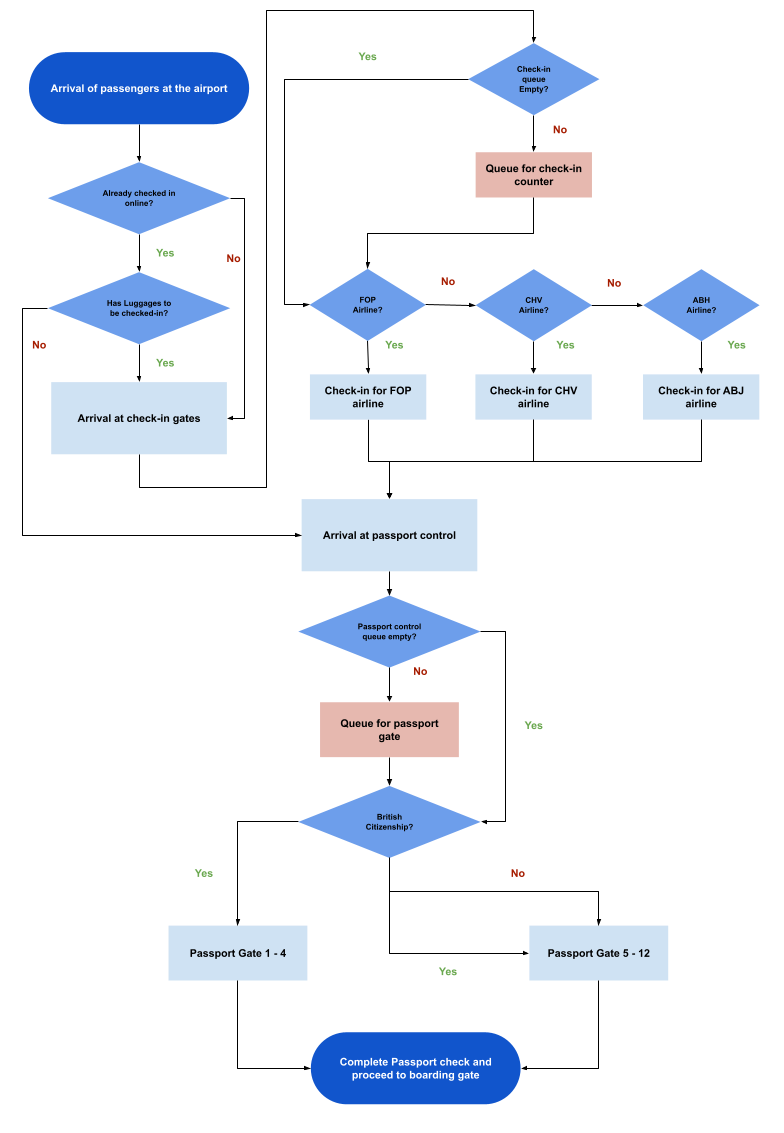

### 1.2 Questions to be addressed

- How many passport control gates are needed to make sure that the waiting time in the passport control stage is less than a minute 98% of times?
- Is the current allocation of check-in desks and passport control gates ideal? If not, what would you propose? Would Josh’s idea work well?

### 1.3 Read the data sheet from the file path

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime as data
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
df_passengers = pd.read_excel('/content/drive/MyDrive/Data.xlsx', sheet_name='Passengers', index_col=0)
df_breakdowns = pd.read_excel('/content/drive/MyDrive/Data.xlsx', sheet_name='Breakdowns', index_col=0)
df_passengers = df_passengers.reset_index()
df_breakdowns = df_breakdowns.reset_index()
df_passengers = df_passengers.iloc[: , 1:]
df_breakdowns = df_breakdowns.iloc[1: , :]

# 2. Data Cleaning

In [3]:
# Format column names and datetime
df_breakdowns.columns = ['Where', 'Start Date', 'Start Time', 'End Date', 'End Time']
df_breakdowns['Start Date'] =  pd.to_datetime(df_breakdowns['Start Date'], format='%Y%m%d')
df_breakdowns['End Date'] =  pd.to_datetime(df_breakdowns['End Date'], format='%Y%m%d')


# Calculate the number and ratio of airlines and passengers' nationality in groups 
CHV_ratio = len(df_passengers[(df_passengers["Airline"] == "CHV")])/len(df_passengers)
FOP_ratio = len(df_passengers[(df_passengers["Airline"] == "FOP")])/len(df_passengers)
ABJ_ratio = len(df_passengers[(df_passengers["Airline"] == "ABJ")])/len(df_passengers)
Brit_ratio = len(df_passengers[df_passengers["Nationality"] =="British"])/len(df_passengers)
Non_Brit_ratio = len(df_passengers[df_passengers["Nationality"] !="British"])/len(df_passengers)

print("------------------ Airline -----------------\n")
print(df_passengers.groupby(df_passengers["Airline"]).describe())
print("------------------ Airline Ratio -----------\n")
print("CHV: " + str(round(CHV_ratio*100,1)) + "%")
print("FOP: " + str(round(FOP_ratio*100,1)) + "%")
print("ABJ: " + str(round(ABJ_ratio*100,1)) + "%")


print("\n------------------ Passengers Nationality -----------------\n")
print(df_passengers.groupby(df_passengers["Nationality"]).describe())
print("\n------------------ Pasengers Nationality Ratio ------------\n")
print("British: " + str(round(Brit_ratio*100,1)) + "%")
print("Non-British: " + str(round(Non_Brit_ratio*100,1)) + "%")

------------------ Airline -----------------

        Nationality                         
              count unique          top freq
Airline                                     
ABJ             159      2  Non-British  114
CHV             280      2  Non-British  198
FOP             561      2  Non-British  391
------------------ Airline Ratio -----------

CHV: 28.0%
FOP: 56.1%
ABJ: 15.9%

------------------ Passengers Nationality -----------------

            Airline                 
              count unique  top freq
Nationality                         
British         297      3  FOP  170
Non-British     703      3  FOP  391

------------------ Pasengers Nationality Ratio ------------

British: 29.7%
Non-British: 70.3%


### 2.3 Perform more data cleaning on location names where the services broke down

In [4]:
# Perform more data cleaning on location names where the services broke down
print("----------------- Service Breakdown Locations ------------------\n")
print(df_breakdowns.groupby(df_breakdowns["Where"]).size())
df_breakdowns.loc[df_breakdowns["Where"]=="Passport Control  1","Where"] = "Passport Control 1"
df_breakdowns.loc[df_breakdowns["Where"]=="Passport Control  9","Where"] = "Passport Control 9"
df_breakdowns.loc[df_breakdowns["Where"]=="Passport Control  12","Where"] = "Passport Control 12"

----------------- Service Breakdown Locations ------------------

Where
Check-in 1              11
Check-in 2              13
Check-in 3               9
Check-in 4              14
Check-in 5               9
Check-in 8               1
Passport Control  1      1
Passport Control  12     1
Passport Control  9      1
Passport Control 1       3
Passport Control 10      5
Passport Control 11      5
Passport Control 12      1
Passport Control 2       4
Passport Control 3       2
Passport Control 4       1
Passport Control 5       2
Passport Control 6       4
Passport Control 7       3
Passport Control 8       6
Passport Control 9       3
dtype: int64


### 2.4 Remove entries where the end times of service breakdown are earlier than the start time

In [5]:
# Remove entries where the end times of service breakdown are earlier than the start time
df_breakdowns.drop(df_breakdowns[(df_breakdowns["Start Date"] == df_breakdowns["End Date"]) & (df_breakdowns["Start Time"] > df_breakdowns["End Time"])].index.tolist(),inplace=True)
df_breakdowns[(df_breakdowns["Start Date"] >= df_breakdowns["End Date"]) & (df_breakdowns["Start Time"] > df_breakdowns["End Time"])]

,Where,Start Date,Start Time,End Date,End Time


In [6]:
# Calculate the time differences of each incident and calculate the average breakdown time in minute
for i in df_breakdowns.index.values:
  time_delta = dt.combine(df_breakdowns.loc[i,"End Date"],df_breakdowns.loc[i,"End Time"]) - dt.combine(df_breakdowns.loc[i,"Start Date"],df_breakdowns.loc[i,"Start Time"])
  time_delta = time_delta.total_seconds()
  df_breakdowns.loc[i,"time_delta"] = time_delta
avg_breakdown_time = round(df_breakdowns.groupby(['Where']).mean()/60,2)



In [7]:
# Breakdowns that last more than a day & breakdown counts by location
print("\n----------------- Breakdown last longer than 1 day ------------------\n")
print(df_breakdowns[(df_breakdowns["time_delta"]/60)>1440])
print("\n----------------- Service Breakdown Locations ------------------\n")
print(df_breakdowns.groupby(["Where"]).size())


----------------- Breakdown last longer than 1 day ------------------

                 Where Start Date Start Time   End Date  End Time  time_delta
72  Passport Control 7 2021-08-15   20:13:19 2021-08-19  10:35:46    310947.0

----------------- Service Breakdown Locations ------------------

Where
Check-in 1              9
Check-in 2             13
Check-in 3              9
Check-in 4             14
Check-in 5              9
Check-in 8              1
Passport Control 1      4
Passport Control 10     5
Passport Control 11     5
Passport Control 12     2
Passport Control 2      3
Passport Control 3      2
Passport Control 4      1
Passport Control 5      2
Passport Control 6      4
Passport Control 7      3
Passport Control 8      6
Passport Control 9      4
dtype: int64


In [8]:
chance_of_breakdown_per_week = pd.DataFrame(round(df_breakdowns.groupby(["Where"]).size()/365*7,2),columns=["chance"])
avg_breakdown_time_per_week = pd.DataFrame(avg_breakdown_time["time_delta"] * chance_of_breakdown_per_week["chance"],columns = ["breakdown(min)"])

# 3. Create the simulation model

### 3.1 Create the dataframe of the mean arrival rate of passenger per duration at the airport

In [9]:
week = ["Mondays", "Tuesdays", "Wednesdays", "Thursdays", "Fridays", "Saturdays","Sundays"]

d = {		
'06:00-11:00': pd.Series([408,500,580,532,476,704,632], index = week),
'11:00-16:00': pd.Series([492,568,616,548,488,792,592], index = week),
'16:00-22:00': pd.Series([392,404,524,460,516,740,664], index = week),
'22:00-23:59': pd.Series([112,124,176,132,104,176,148], index = week)
}
                        
df_mean_arrival = pd.DataFrame(d)

### 3.2 Functions & classes required for the simulation

In [10]:
# ------------------------------------------------------------------------------------------------

# Switch Class
# iterate over the intervals if the argument is in that interval, return its associated value
class Switch(dict):
    def __getitem__(self, item):
        for key in self.keys():                 
            if item in key:                      
                return super().__getitem__(key)  
        raise KeyError(item)     

# Help determine which time duration in the dataframe
arrival_switch = Switch({
    range(6, 11): 0,
    range(11, 16): 1,
    range(16, 22): 2,
    range(22, 24): 3
})

# Help determine the number of hours in that time duration to find average arrival rate per hour
arrival_duration = Switch({
    range(6, 11): 5,
    range(11, 16): 5,
    range(16, 22): 6,
    range(22, 24): 2
})


def service_time_gate(mean, sigma, n):
  arrival_test = np.log(np.random.normal(mean,sigma,n))

  arrival_test_mean = np.mean(arrival_test)
  arrival_test_std = np.std(arrival_test)

  check_in_df = np.random.lognormal(arrival_test_mean, arrival_test_std, n)
  return check_in_df



### 3.3 Simulation Algorithm

In [11]:
# Start of the function
def Sim_Queuing_Model(day_input, num_CI, num_PC, CI_combine, Rep_CI_MWT_Plot, Rep_PC_MWT_Plot, Rep_MWT_Plot, Rep_less_than_a_min_ratio):

  # ----------- 1. Create a dataframe including all passenger information -------------- #
  # Generate the time of arrival at the airport for each passenger

  day_input = day_input
  num_CI = num_CI
  num_PC = num_PC
  
  
  IAT_df = pd.DataFrame(columns = ["Day","IAT"])
  #day_input = 8
  for d in range(0, day_input):
    for j in range(6,24):
      
      if(d >=7):
        i = d-7
      else:
        i = d
        
      hr_duration = arrival_switch[j]
      passenger_per_hr = int(df_mean_arrival.iloc[i,hr_duration]/arrival_duration[j])
      day = df_mean_arrival.index[i]
      hr = j
      temp = [day for x in range(passenger_per_hr)]
      temp2 = np.random.exponential(1/passenger_per_hr,passenger_per_hr)*60
      IAT_hr = pd.DataFrame(list(zip(temp,temp2)),columns = ["Day","IAT"])
      IAT_df = IAT_df.append(IAT_hr)
    

  IAT_df = IAT_df.reset_index(drop=True)

  # Count the number of passengers

  num_Passengers = len(IAT_df)
  num_Passengers

  # Assign the airline, nationality, pre check-in, and luggage labels into the dataframe by the given ratio from the scenario brief in section 1.1 and the provided passenger datasets

  IAT_df["Airline"] = np.random.choice(["CHV", "FOP", "ABJ"], len(IAT_df), p=[CHV_ratio, FOP_ratio, ABJ_ratio])
  IAT_df["Nationality"] = np.random.choice(["British", "Non-British"], len(IAT_df), p=[Brit_ratio, Non_Brit_ratio])
  IAT_df["Checked_in"] = np.random.choice(["Yes", "No"], len(IAT_df), p=[0.57, 0.43])
  IAT_checked_in = IAT_df[IAT_df["Checked_in"] == "Yes"]
  IAT_checked_in["Luggage"] = np.random.choice(["No", "Yes"], len(IAT_df[IAT_df["Checked_in"] == "Yes"]), p=[0.68, 0.32])
  IAT_no_checked_in = IAT_df.drop(IAT_checked_in.index)
  IAT_no_checked_in["Luggage"] = "Invalid"
  IAT_df = pd.concat([IAT_checked_in, IAT_no_checked_in]).sort_index()

  # Generate Service time for check-in gate & passport gates for Brits & Non-Brits

  num_Brit_Customers = len(IAT_df[IAT_df["Nationality"]=="British"])
  num_Non_Brit_Customers = len(IAT_df[IAT_df["Nationality"]!="British"])


  ST_checkin = service_time_gate(5,0.5,num_Passengers)
  ST_passport_brits = service_time_gate(4,0.1,num_Brit_Customers)
  ST_passport_non_brits = service_time_gate(5,0.5,num_Non_Brit_Customers)

  # Insert Check in service time for passengers, and assign 0 to those who checked-in with no luggage
  IAT_df["CI_ST"] = ST_checkin
  IAT_df["PC_ST"] = np.nan
  IAT_df.loc[((IAT_df["Checked_in"] == "Yes") & (IAT_df["Luggage"] == "No")), "CI_ST"] = 0

  # Insert passport gate service time for British and Non-British passengers accordingly
  IAT_df.loc[(IAT_df["Nationality"] == "British"),"PC_ST"] = ST_passport_brits
  IAT_df.loc[(IAT_df["Nationality"] == "Non-British"), "PC_ST"] = ST_passport_non_brits

  # Reorder Column name for better understanding of the dataframe
  IAT_df = IAT_df[['Day', 'Airline', 'Nationality', 'Checked_in', 'Luggage','IAT','CI_ST','PC_ST']]


  # ----------- Create Variable --------------#
  # Insert time of arrival for each passenger
  time = 0
  for i in range(num_Passengers):
      time += IAT_df.loc[i,"IAT"]
      IAT_df.loc[i,"ent_Time"] = time
  # Create check-in counter's start, end, and wait time attributes
  IAT_df["CI_waiting_Time"] = np.nan
  IAT_df["CI_serv_Start_Time"] = np.nan
  IAT_df["CI_serv_End_Time"] = np.nan

  # ----------- Create service desk dataframes for check-in counters and passport gates --------- #
  #num_CI = 20
  #num_PC = 12
  CI_counter = []
  PC_counter = []
  for i in range(1,num_CI+1):
    CI_counter.append(i)
  for i in range(1,num_PC+1):
    PC_counter.append(i)
  status = ["occupied", "current_customer", "lastest_serv_Start_Time","lastest_serv_End_Time"]
  df_CI = pd.DataFrame(0, index = CI_counter, columns = status)
  df_PC = pd.DataFrame(0, index = PC_counter, columns = status)


  # Sort the dataset based on airlines and the time of arrival
  IAT_df = IAT_df.sort_values(['Airline','ent_Time'], ascending=[False, True])
  IAT_df.index = IAT_df.index.sort_values()

  # Insert the information of the first passenger 
  if ((IAT_df.loc[0,"Checked_in"] == "Yes") & (IAT_df.loc[0,"Luggage"] == "No")):
    IAT_df.loc[0,"CI_serv_Start_Time"] = 0
    IAT_df.loc[0,"CI_serv_End_Time"] = 0
    IAT_df.loc[0,"CI_waiting_Time"] = 0
  else:
    IAT_df.loc[0,"CI_serv_Start_Time"] = IAT_df.loc[0,"ent_Time"]
    IAT_df.loc[0,"CI_serv_End_Time"] = IAT_df.loc[0,"CI_serv_Start_Time"] + IAT_df.loc[0,"IAT"]
    IAT_df.loc[0,"CI_waiting_Time"] = 0
    df_CI.loc[1,"occupied"] = 1
    df_CI.loc[1,"current_customer"] = 0
    df_CI.loc[1,"lastest_serv_Start_Time"] = IAT_df.loc[0,"CI_serv_Start_Time"]
    df_CI.loc[1,"lastest_serv_End_Time"] = IAT_df.loc[0,"CI_serv_End_Time"]

  current_Node = 0

  # CI_Waiting_Time = 0
  # PC_Waiting_Time = 0
  # sum_Waiting_Time = 0
  # Function to assign check-in-gate

  def airline_to_gate(argument):
      i=1
      while (i == 1):
        a = int(round(num_CI*0.4,0))
        b = int(round(num_CI*0.35,0))
        c = int(round(num_CI*0.25,0))
        if ((a+b+c) == num_CI):
          i -= 1
        
        elif ((a+b+c) > num_CI):
          c -= abs((a+b+c)-num_CI)
          i -= 1
        else:
          c += abs((a+b+c)-num_CI)
          i -= 1
        switcher = {
          "FOP": [0,a],
          "CHV": [a,a+b],
          "ABJ": [a+b,a+b+c],
      }
      return switcher.get(argument, "nothing")   

  def airline_to_gate_combined(argument):
      a = int(round(num_CI*0.4,0))
      b = int(round(num_CI*0.6,0))
        
        
      switcher = {
          "FOP": [0,a],
          "CHV": [a,a+b],
          "ABJ": [a,a+b],
      }
      return switcher.get(argument, "nothing")

  # Assign the check-in counters based on airline information
 
  if(CI_combine == True):
    FOP_CI = (df_CI[airline_to_gate_combined("FOP")[0]:airline_to_gate_combined("FOP")[1]])
    CHV_CI = (df_CI[airline_to_gate_combined("CHV")[0]:airline_to_gate_combined("CHV")[1]])
    ABJ_CI = (df_CI[airline_to_gate_combined("ABJ")[0]:airline_to_gate_combined("ABJ")[1]])  
  else:
    FOP_CI = (df_CI[airline_to_gate("FOP")[0]:airline_to_gate("FOP")[1]])
    CHV_CI = (df_CI[airline_to_gate("CHV")[0]:airline_to_gate("CHV")[1]])
    ABJ_CI = (df_CI[airline_to_gate("ABJ")[0]:airline_to_gate("ABJ")[1]])

  CI_list = {"FOP": FOP_CI,"CHV":CHV_CI,"ABJ":ABJ_CI}

  # ----------------- Calculate the service time for each passengers at the check-in counters ---------------- #
  while(current_Node < num_Passengers-1):
    current_Node += 1 # Next Passengers


    # Check the airline the passenger is taking and assign him to the associated check-in counters
    for airline, CI in CI_list.items():
      
      if(IAT_df.loc[current_Node,"Airline"]==airline):
        
        # Find the check-in counter that finishes service first
        earliest = CI['lastest_serv_End_Time'].idxmin()

        # Filter out thos that checked in the night prior with no luggage
        if(IAT_df.loc[current_Node,"CI_ST"] == 0):
          IAT_df.loc[current_Node,"CI_waiting_Time"] = 0
          IAT_df.loc[current_Node,"CI_serv_Start_Time"] = 0
          IAT_df.loc[current_Node,"CI_serv_End_Time"] = 0
        
        # If the passenger arrives after the check-in counters finish services
        elif (IAT_df.loc[current_Node, "ent_Time"] > CI.loc[earliest,"lastest_serv_End_Time"]):    
          CI.loc[earliest,"lastest_serv_Start_Time"] = IAT_df.loc[current_Node,"ent_Time"]
          IAT_df.loc[current_Node,"CI_serv_Start_Time"] = CI.loc[earliest,"lastest_serv_Start_Time"]
          CI.loc[earliest,"lastest_serv_End_Time"] = IAT_df.loc[current_Node,"CI_serv_Start_Time"] + IAT_df.loc[current_Node,"CI_ST"]
          IAT_df.loc[current_Node,"CI_serv_End_Time"] = CI.loc[earliest,"lastest_serv_End_Time"]
          IAT_df.loc[current_Node,"CI_waiting_Time"] = (IAT_df.loc[current_Node,"CI_serv_Start_Time"] - IAT_df.loc[current_Node,"ent_Time"])
        # If the passenger arrives before the check-in counters finish services
        else:
          CI.loc[earliest,"lastest_serv_Start_Time"] = CI.loc[earliest,"lastest_serv_End_Time"]
          IAT_df.loc[current_Node,"CI_serv_Start_Time"] = CI.loc[earliest,"lastest_serv_Start_Time"]
          CI.loc[earliest,"lastest_serv_End_Time"] = IAT_df.loc[current_Node,"CI_serv_Start_Time"] + IAT_df.loc[current_Node,"CI_ST"]
          IAT_df.loc[current_Node,"CI_serv_End_Time"] = CI.loc[earliest,"lastest_serv_End_Time"] 
          IAT_df.loc[current_Node,"CI_waiting_Time"] = (IAT_df.loc[current_Node,"CI_serv_Start_Time"] - IAT_df.loc[current_Node,"ent_Time"])

    continue  


  # ------------------ Move on to Passport Check Queue -------------------- #
  PC_df = IAT_df

  # Insert start, end, and waiting time at the passport gate, and sort the dataframe by time of arrival at the airport
  PC_df["PC_waiting_Time"] = np.nan
  PC_df["PC_serv_Start_Time"] = np.nan
  PC_df["PC_serv_End_Time"] = np.nan
  PC_df = PC_df.sort_values(['ent_Time'], ascending=[True])
  PC_df = PC_df.reset_index(drop=True)

  # Function to assign passport gates
  def CI_to_PC(argument):
      i=1
      while(i == 1):
        a = int(round(num_PC*0.33,0))
        b = int(round(num_PC*0.66,0))
        if((a+b)==num_PC):
          i -= 1
        else:
          b += 1
          i -= 1
      switcher = {
          "British": [0,a+b],
          "Non-British": [a,a+b],
      }
      return switcher.get(argument, "nothing")

  # Assign the passport gates based on Nationality
  Brit_PC = (df_PC[CI_to_PC("British")[0]:CI_to_PC("British")[1]])
  Non_Brit_PC = (df_PC[CI_to_PC("Non-British")[0]:CI_to_PC("Non-British")[1]])
  PC_list = {"British": Brit_PC,"Non-British":Non_Brit_PC}

  # ----------------- Calculate the service time for each passengers at the passport gates ---------------- #

  current_Node = 0
  while(current_Node <= num_Passengers-1):
        
        # Check the nationality and the passport gates the passenger is allowed to go through    
        for nationality, PC in PC_list.items():
          # Check the nationality
          if(PC_df.loc[current_Node,"Nationality"]==nationality):
            # Find the passport gate that finishes the first
            earliest = PC['lastest_serv_End_Time'].idxmin()
            # For those that skipped check-in gate
            if(PC_df.loc[current_Node,"CI_serv_End_Time"] == 0):
              # If the passenger arrives after the passport gate that finishes first
              if(PC_df.loc[current_Node,"ent_Time"] > PC.loc[earliest,"lastest_serv_End_Time"]):
                PC.loc[earliest,"lastest_serv_Start_Time"] = PC_df.loc[current_Node,"ent_Time"]
                PC.loc[earliest,"lastest_serv_End_Time"] = PC.loc[earliest,"lastest_serv_Start_Time"] + PC_df.loc[current_Node,"PC_ST"]
                PC_df.loc[current_Node,"PC_serv_Start_Time"] = PC.loc[earliest,"lastest_serv_Start_Time"]
                PC_df.loc[current_Node,"PC_serv_End_Time"] = PC.loc[earliest,"lastest_serv_End_Time"]
                PC_df.loc[current_Node,"PC_waiting_Time"] = PC_df.loc[current_Node,"PC_serv_Start_Time"] - PC_df.loc[current_Node,"ent_Time"]
              # If the passenger arrives before the passport gate that finishes first
              else:
                PC.loc[earliest,"lastest_serv_Start_Time"] = PC.loc[earliest,"lastest_serv_End_Time"]
                PC.loc[earliest,"lastest_serv_End_Time"] = PC.loc[earliest,"lastest_serv_Start_Time"] + PC_df.loc[current_Node,"PC_ST"]
                PC_df.loc[current_Node,"PC_serv_Start_Time"] = PC.loc[earliest,"lastest_serv_Start_Time"]
                PC_df.loc[current_Node,"PC_serv_End_Time"] = PC.loc[earliest,"lastest_serv_End_Time"]
                PC_df.loc[current_Node,"PC_waiting_Time"] = PC_df.loc[current_Node,"PC_serv_Start_Time"] - PC_df.loc[current_Node,"ent_Time"]
            # For those that went through check-in process
            else:
              # If the passenger that checked in arrives at the passport gate queue after the passport gate that finishes first
              if(PC_df.loc[current_Node,"CI_serv_End_Time"] > PC.loc[earliest,"lastest_serv_End_Time"]):
                PC.loc[earliest,"lastest_serv_Start_Time"] = PC_df.loc[current_Node,"CI_serv_End_Time"]
                PC.loc[earliest,"lastest_serv_End_Time"] = PC.loc[earliest,"lastest_serv_Start_Time"] + PC_df.loc[current_Node,"PC_ST"]
                PC_df.loc[current_Node,"PC_serv_Start_Time"] = PC.loc[earliest,"lastest_serv_Start_Time"]
                PC_df.loc[current_Node,"PC_serv_End_Time"] = PC.loc[earliest,"lastest_serv_End_Time"]
                PC_df.loc[current_Node,"PC_waiting_Time"] = PC_df.loc[current_Node,"PC_serv_Start_Time"] - PC_df.loc[current_Node,"CI_serv_End_Time"]
              # If the passenger that checked in arrives at the passport gate queue before the passport gate that finishes first
              else:
                PC.loc[earliest,"lastest_serv_Start_Time"] = PC.loc[earliest,"lastest_serv_End_Time"]
                PC.loc[earliest,"lastest_serv_End_Time"] = PC.loc[earliest,"lastest_serv_Start_Time"] + PC_df.loc[current_Node,"PC_ST"]
                PC_df.loc[current_Node,"PC_serv_Start_Time"] = PC.loc[earliest,"lastest_serv_Start_Time"]
                PC_df.loc[current_Node,"PC_serv_End_Time"] = PC.loc[earliest,"lastest_serv_End_Time"]
                PC_df.loc[current_Node,"PC_waiting_Time"] = PC_df.loc[current_Node,"PC_serv_Start_Time"] - PC_df.loc[current_Node,"CI_serv_End_Time"]
          
        # Next passenger in the Passport queue
        current_Node += 1
        
  # ----------------- Calculate wait time and ratio --------------------- #  

  CI_WTs = PC_df["CI_waiting_Time"].sum()
  CI_MWTs = CI_WTs/len(PC_df)
  PC_WTs = PC_df["PC_waiting_Time"].sum()
  PC_MWTs = PC_WTs/len(PC_df)
  MWTs = (CI_WTs + PC_WTs)/len(PC_df)
  less_than_a_min_ratio = len(PC_df[PC_df["PC_waiting_Time"]<1])/len(PC_df)


  # ---------------- Visualization Methods --------------------- #

  if(Rep_CI_MWT_Plot == True):
    return round(CI_MWTs,2)
      
  if(Rep_PC_MWT_Plot == True):
    return round(PC_MWTs,2)
      
  if(Rep_MWT_Plot == True):
    return round(MWTs,2)
     
  if(Rep_less_than_a_min_ratio == True):
    return round(less_than_a_min_ratio,2)

# 4. Simulation Outcome

### Question 1: Number of passport gates required to make sure that the waiting time in the passport control stage is less than a minute 98% of times.


In [ ]:
counts = []
ratio = []
for i in range(12,30):
  counts.append(i)
  ratio.append(Sim_Queuing_Model(7, 20, i, False, False, False, False, True))

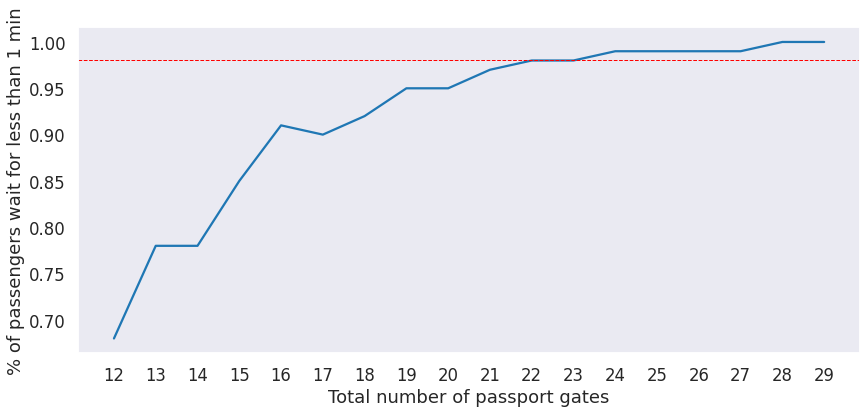

In [46]:
df = pd.DataFrame(list(zip(counts,ratio)),columns=['Total number of passport gates','% of passengers wait for less than 1 min'])
#plt.rcParams["figure.figsize"] = (14,6)
plt.xticks(counts)
graph = sns.lineplot(data=df,x='Total number of passport gates',y='% of passengers wait for less than 1 min')
graph.axhline(0.98,color = "r", linewidth = 1, linestyle='dashed')

### Question 2: Should the airport combine check-in desks of FOP and CHV airlines? 

In [47]:
Sim_Queuing_Model(7, 20, 12, False, True, False, False, False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


0.01

In [48]:
Sim_Queuing_Model(7, 20, 12, True, True, False, False, False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


355.83

1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


2
3
4
5
6
7
1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


2
3
4
5
6
7
1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


2
3
4
5
6
7
1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


2
3
4
5
6
7


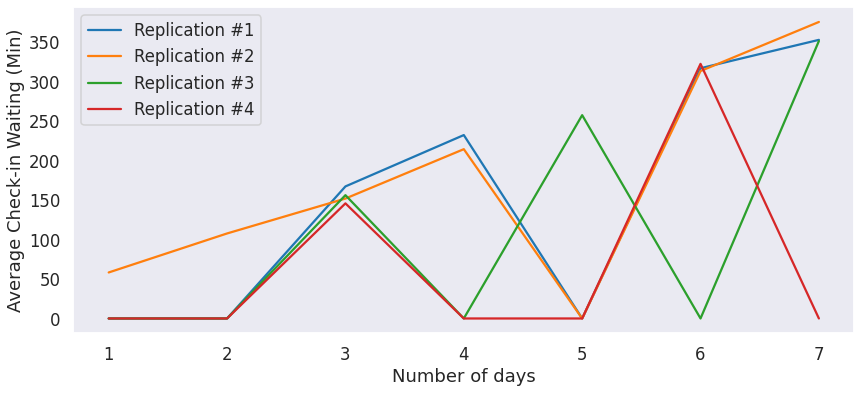

In [58]:
for rep in range(1,5):
  avg_CI_WT = []
  day_count = []
  days = 7
  for day in range(1,days+1):
    print(day)
    day_count.append(day)
    avg_CI_WT.append(Sim_Queuing_Model(day,20,12,True,True,False,False,False))
  df = pd.DataFrame(list(zip(day_count,avg_CI_WT)),columns=['Number of days','Average Check-in Waiting (Min)'])
  plt.rcParams["figure.figsize"] = (14,6)
  sns.lineplot(data=df,x='Number of days',y='Average Check-in Waiting (Min)')
plt.legend(labels=['Replication #1','Replication #2','Replication #3','Replication #4','Replication #5'])

1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


2
3
4
5
6
7
1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


2
3
4
5
6
7
1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


2
3
4
5
6
7
1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


2
3
4
5
6
7


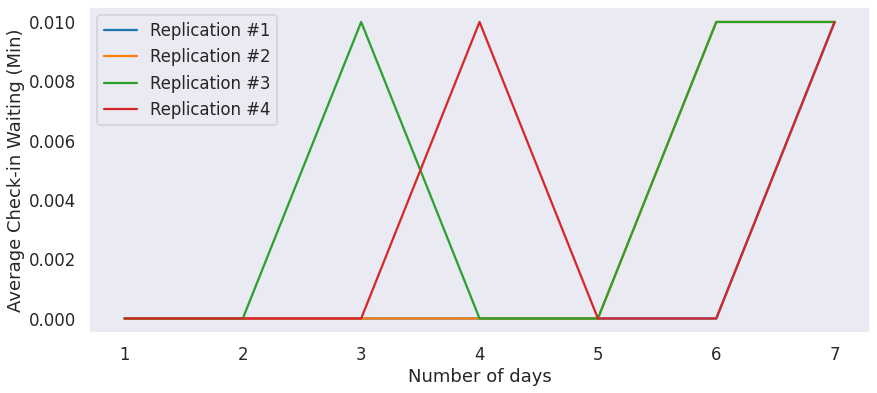

In [59]:
for rep in range(1,5):
  avg_CI_WT = []
  day_count = []
  days = 7
  for day in range(1,days+1):
    print(day)
    day_count.append(day)
    avg_CI_WT.append(Sim_Queuing_Model(day,20,12,False,True,False,False,False))
  df = pd.DataFrame(list(zip(day_count,avg_CI_WT)),columns=['Number of days','Average Check-in Waiting (Min)'])
  plt.rcParams["figure.figsize"] = (14,6)
  sns.lineplot(data=df,x='Number of days',y='Average Check-in Waiting (Min)')
plt.legend(labels=['Replication #1','Replication #2','Replication #3','Replication #4','Replication #5'])

### Question 3: Number of passport gates required to significantly lower the average wait time

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

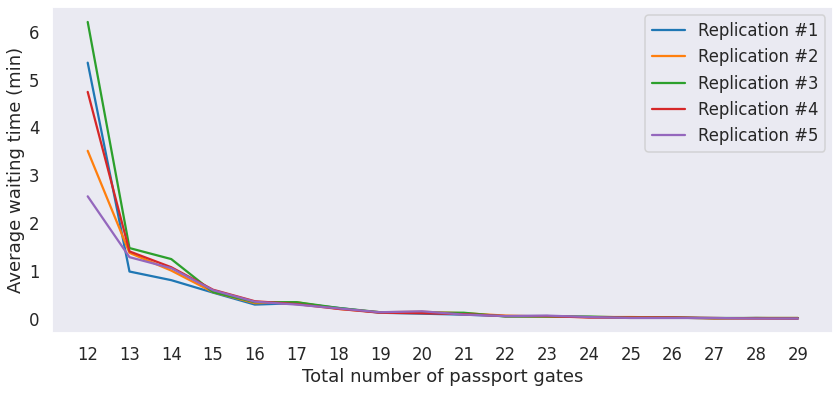

In [63]:
for rep in range(1,6):
  counts = []
  MWTs = []
  for i in range(12,30):
    counts.append(i)
    MWTs.append(Sim_Queuing_Model(7, 20, i, False, False, False, True, False))
  df = pd.DataFrame(list(zip(counts,MWTs)),columns=['Total number of passport gates','Average waiting time (min)'])
  plt.rcParams["figure.figsize"] = (14,6)
  plt.xticks(counts)
  sns.lineplot(data=df,x='Total number of passport gates',y='Average waiting time (min)')
plt.legend(labels=['Replication #1','Replication #2','Replication #3','Replication #4','Replication #5'])

In [69]:
#os.system('jupyter nbconvert --execute --to html Graded_Assignment_Develop_and_Run_Simulation.ipynb')

65280

In [76]:
!jupyter nbconvert --to html /content/drive/MyDrive/Graded_Assignment_Develop_and_Run_Simulation.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/Graded_Assignment_Develop_and_Run_Simulation.ipynb to html
[NbConvertApp] Writing 812948 bytes to /content/drive/MyDrive/Graded_Assignment_Develop_and_Run_Simulation.html


In [73]:
jupyter nbconvert Graded_Assignment_Develop_and_Run_Simulation.ipynb

SyntaxError: ignored

In [ ]:
/content/drive/MyDrive/Graded_Assignment_Develop_and_Run_Simulation.ipynb